# Градиентный бустинг. Стекинг

Структура:  
1. Случайный лес и Градиентный бустинг (Random Forest & Gradient Boosting)
2. Классификатор на основе градиентного бустинга для выявления спама
3. Адаптивный бустинг (AdaBoost - Adaptive Boosting)
4. Стекинг (Stacking): блендинг и классический стекинг

In [1]:
# Подготовка среды
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 3)

from scipy.stats.distributions import randint
from itertools import combinations
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.base import clone

# 1. Случайный лес и Градиентный бустинг   
## (Random Forest & Gradient Boosting)

**Случайный лес** — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков (RSS - Random Subspaces).

**Основные недостатки случайного леса:**
- глубокие деревья - высокая вычислительная мощность, особенно в случае большой выборки или большого количества признаков;
- неглубокие деревья перестают улавливать сложные закономерности. Это может привести к значительному сдвигу (bias).
- деревья строятся независимо (ненаправленный процесс) - возникает необходимость построения огромного числа деревьев.  

**Бустинг (Boosting)** — продвинутый метод построения ансамблей, где алгоритмы строятся итеративно, компенсируя ошибки предыдущих. Базовые алгоритмы приближают антиградиент функции ошибки. Бороться с переобучением можно при помощи введения шага или бэггинга (Стохастический градиентный бустинг).  
**Примеры возможных функций потерь:**  
- Среднеквадратичная ошибка (в задаче регрессии):  
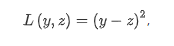  
- Логистическая функция потерь (в задаче классификации):  
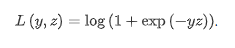  

###  Проиллюстрируем зависимость качества Random Forest от глубины дереьев 

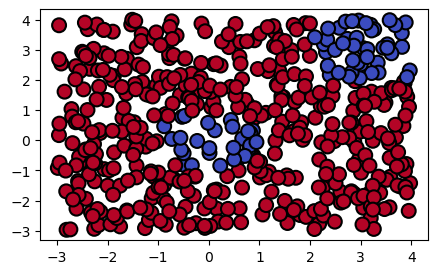

In [41]:
RANDOM_SEED = 139

def get_labels(data):
    labels = []
    for idx, item in enumerate(data):
        if item[0]**2 + item[1]**2 < 1:
            labels.append(0)
        elif item[0] > 2 and item[1] > 2:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

N = 500
train_data = 7 * np.random.random_sample((N,2)) - np.array([3,3])

train_labels = get_labels(train_data)

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

shallow_rf = RandomForestClassifier(n_estimators = 5, max_depth = 3, n_jobs = -1, 
                                    random_state = RANDOM_SEED)
deep_rf = RandomForestClassifier(n_estimators = 5, max_depth = 6, n_jobs = -1, 
                                 random_state = RANDOM_SEED)

# training the tree
shallow_rf.fit(train_data, train_labels)
deep_rf.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted_shallow = shallow_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
predicted_deep = deep_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, 
            cmap = 'coolwarm', edgecolors = 'black', linewidth = 1.5);

Text(0.5, 1.0, 'Deep Random Forest')

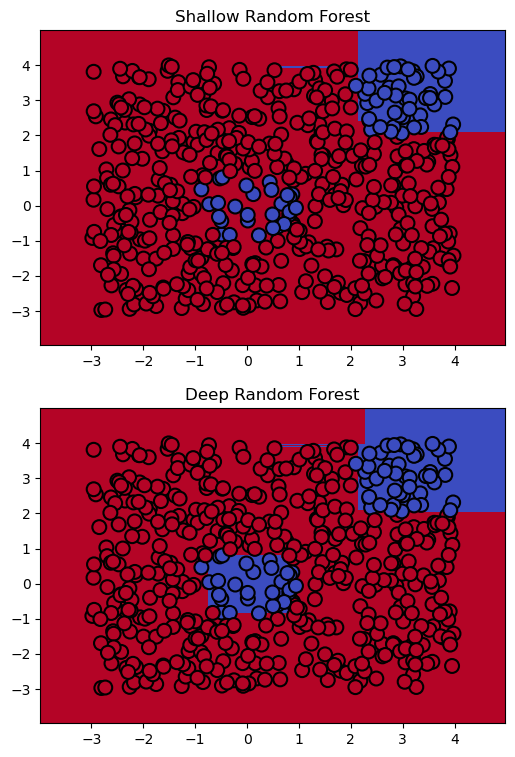

In [42]:
fig, ax = plt.subplots(2, 1, figsize = (6, 9))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap = 'coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, 
            cmap = 'coolwarm', edgecolors = 'black', linewidth = 1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap = 'coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, 
            cmap = 'coolwarm', edgecolors = 'black', linewidth = 1.5);
ax[1].set_title('Deep Random Forest')

# 2. Классификатор на основе градиентного буст. для выявления спама

- Загрузим данные, проведем небольшую предобработку.  
- Обучим модель градиентного бустинга. 
- Настроим параметры с помощью GridSearchCV.

In [219]:
# Загрузим данные 
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
display(df.head(3))
display(df.info())
print(f'Посмотрим на соотношение значений целевой переменной (y/n): \n{df.yesno.value_counts()}')

,Unnamed: 0,crl.tot,dollar,bang,money,n000,make,yesno
0,1,278,0.000,0.778,0.00,0.00,0.00,y
1,2,1028,0.180,0.372,0.43,0.43,0.21,y
2,3,2259,0.184,0.276,0.06,1.16,0.06,y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4601 non-null   int64  
 1   crl.tot     4601 non-null   int64  
 2   dollar      4601 non-null   float64
 3   bang        4601 non-null   float64
 4   money       4601 non-null   float64
 5   n000        4601 non-null   float64
 6   make        4601 non-null   float64
 7   yesno       4601 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 287.7+ KB


None

Посмотрим на соотношение значений целевой переменной (y/n): 
n    2788
y    1813
Name: yesno, dtype: int64


In [220]:
# Переименуем столбец "yesno" в "spam" и трансформируем значения: 1 - y (является спамом),  0 – n (не является спамом)
# Удалим первый столбец как нерепрезентативный

df.yesno = (df.yesno == 'y').astype('int32')
df.rename(columns = {'yesno' : 'spam'}, inplace = True)
df = df.drop('Unnamed: 0', axis = 1)

# Разделим данные на X и y 
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Cоздадим новые признаки путем попарного перемножения имеющихся признаков друг на друга
features_list = list(combinations(X, 2))
print(features_list)
m = 1
for col_1, col_2 in features_list:
    X[f'New_feature_{m}'] =  X[col_1] * X_2[col_2]
    m += 1
    
display(X.head(3))
X.shape

[('crl.tot', 'dollar'), ('crl.tot', 'bang'), ('crl.tot', 'money'), ('crl.tot', 'n000'), ('crl.tot', 'make'), ('dollar', 'bang'), ('dollar', 'money'), ('dollar', 'n000'), ('dollar', 'make'), ('bang', 'money'), ('bang', 'n000'), ('bang', 'make'), ('money', 'n000'), ('money', 'make'), ('n000', 'make')]


,crl.tot,dollar,bang,money,n000,make,New_feature_1,New_feature_2,New_feature_3,New_feature_4,...,New_feature_6,New_feature_7,New_feature_8,New_feature_9,New_feature_10,New_feature_11,New_feature_12,New_feature_13,New_feature_14,New_feature_15
0,278,0.000,0.778,0.00,0.00,0.00,0.000,216.284,0.00,0.00,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.0000
1,1028,0.180,0.372,0.43,0.43,0.21,185.040,382.416,442.04,442.04,...,0.066960,0.07740,0.07740,0.03780,0.15996,0.15996,0.07812,0.1849,0.0903,0.0903
2,2259,0.184,0.276,0.06,1.16,0.06,415.656,623.484,135.54,2620.44,...,0.050784,0.01104,0.21344,0.01104,0.01656,0.32016,0.01656,0.0696,0.0036,0.0696


(4601, 21)

- Разделим получившися данные на обучающую и тестовую выборки в соотношение 80:20.  
- Обучим модель GradientBoostingClassifier с параметрами по умолчанию (learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None) и посчитаем Accuracy.  
- Во всех методах, где присутствует случайность, укажем random_state=42. Это будет baseline. 

In [221]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, test_size = 0.2)
gr = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, min_samples_split = 2, 
                                min_samples_leaf = 1, subsample = 1, max_features = None, 
                                random_state = 42).fit(X_train, y_train)
y_pred = gr.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy:.03}')

Accuracy: 0.865


,Feature_Importance
crl.tot,0.029674
dollar,0.140770
bang,0.042614
money,0.006090
n000,0.024777


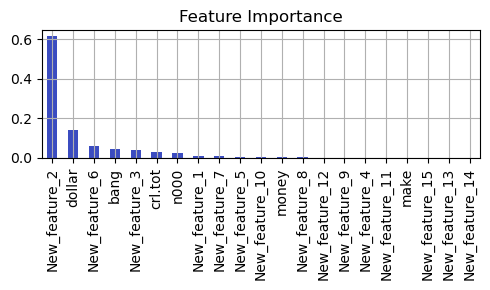

In [272]:
# Оценим вклад каждого признака. Построим график
feature_importances = gr.feature_importances_
feature_importances_df = pd.DataFrame(feature_importances, index = X.columns, columns = ['Feature_Importance']) 
display(feature_importances_df[:5])
feature_importances_df.Feature_Importance.sort_values(ascending = False) \
                      .plot(kind = 'bar', grid = True, colormap = 'coolwarm', title = 'Feature Importance')
plt.tight_layout()

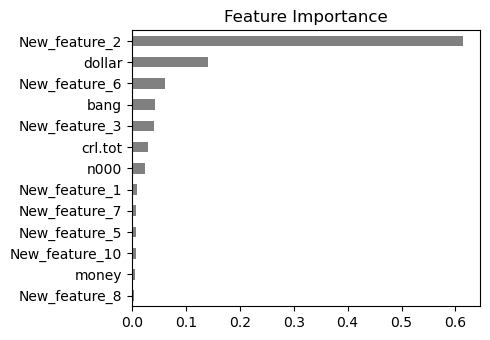

In [356]:
feature_importances_df.Feature_Importance.sort_values(ascending = True)[-13:]  \
                        .plot(kind = 'barh', title = 'Feature Importance', figsize = (5, 3.5), color = 'gray')
plt.tight_layout()

**Настройка параметров при помощи GridSearchCV**  

In [316]:
params = {'learning_rate' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
          'n_estimators' : [100, 250, 500, 750, 1000, 1250, 1500, 1750]}

gs = GridSearchCV(gr, scoring = 'accuracy', n_jobs = -1, cv = 5, param_grid = params).fit(X_train, y_train)
best_params = gs.best_params_
best_model = gs.best_estimator_
score = gs.best_score_ 

print(f'Лучшие параметры, предложенные GridSearchCV:\n{best_params}')
print(f'Лучшая модель:\n{best_model}')
print(f'\nScore: {score:.3}')

Лучшие параметры, предложенные GridSearchCV:
{'learning_rate': 0.01, 'n_estimators': 1250}
Лучшая модель:
GradientBoostingClassifier(learning_rate=0.01, n_estimators=1250,
                           random_state=42, subsample=1)

Score: 0.884


**Воспользуемся GridSearchCV для подбора максимальной глубины (max_depth):**    
- В качестве estimator используем градиентный бустинг с раннеее подобранными параметрами и random_state=42.  
- Переберём все значения max_depth от 5 до 15 включительно. 

In [323]:
gs_new = GridSearchCV(best_model, scoring = 'accuracy', n_jobs = -1, cv = 5, 
                      param_grid = {'learning_rate' : [0.01], 
                                    'n_estimators' : [1250], 'max_depth' : list(range(5,16))}).fit(X_train, y_train)
gs_new_params = gs_new.best_params_
gs_new_score_ = gs_new.best_score_
print(f'Лучшие параметры:\n{gs_new_params}')
print(f'\nScore: {gs_new_score_:.3}')

Лучшие параметры:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1250}

Score: 0.885


# 3. Адаптивный бустинг (AdaBoost - Adaptive Boosting)  
**AdaBoost** - это итеративный алгоритм построения ансамбля. На каждой новой итерации строится дерево решений, корректирующее ответы всех предыдущих. Ошибка комбинации предыдущих алгоритмов учитывается за счет присвоения весов объектам обучающей выборки. AdaBoost использует немного параметров и прост в имплементации, чувствителен к выбросам, устойчив к переобучению (когда в данных мало шума), необходимо адаптировать для случая несбалансированных классов.

**Основные достоинства алгоритма:**
- Алгоритм прост.
- Накладные расходы бустинга минимальны. Время построения определяется временем построения базовых моделей.
- Показывает хорошую обобщающую способность.
- Имеет возможность идентификации шумовых объектов.

**Основные недостатки алгоритма:**  
- Жадное добавление алгоритмов приводит к неоптимальности композиции.
- Склонен к переобучению при наличии шума в данных (экспоненциальная функция потерь слишком сильно увеличивает веса сложно идентифицируемых объектов).  
- Переобучается при «малом» количестве данных.

**Алгоритм посмтроения AdaBoost:**

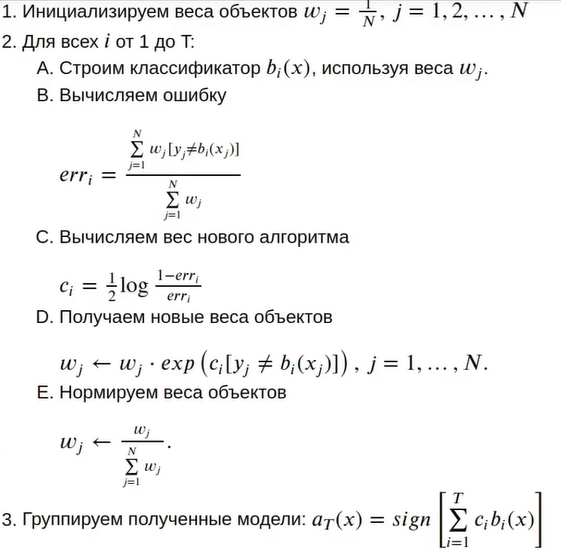

In [ ]:
def AdaBoost_scratch(X, y, M = 10, learning_rate = 1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [], [], [], []

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes = 2)
        estimator.fit(X, y, sample_weight = sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        #estimator_error = TODO 
        
        # Вычисляем вес нового алгоритма
        #estimator_weight =  TODO

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M = 10, learning_rate = 0.001)

In [ ]:
estimator_error = log_loss(y, y_predict)
estimator_weight = 1/2 *log((1-estimator_error) / estimator_error)

# 4. Стекинг (Stacking): блендинг и классический стекинг

**Стекинг** позволяет объединять ответы нескольких алгоритмов первого уровня (базовых моделей) в один итоговый ответ при помощи нового алгоритма обучения (мета-модель).  
- **Базовая модель** обучается независимо от остальных. Цель базовых алгоритмов - создать новые признаки для обучения мета-алгоритма.  
- **Мета-модель** использует предсказания базовых моделей как признаки и принимает итоговое решение.     


**Блендинг** (упрощенный вариант стекинга):    

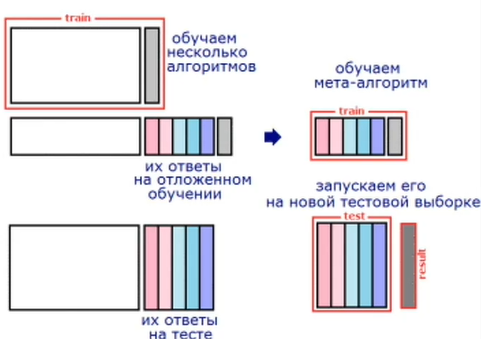     


**Классический стекинг** (с применением кросс-валидации):     

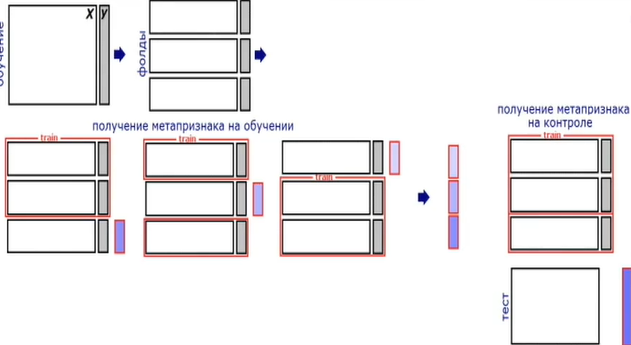

**Общие правила стекинга:**    
- В качестве базовых моделей необходимо выбирать модели различной природы.    
- Рекомендуется применять регрессоры для мета-моделей.    
- Можно использовать подходы из кросс-валидации (разбиение по фолдам, бутстреп) для получения различных моделей.      
- Делать стекинг с большим количеством уровней при наличии достаточного количества данных и времени.  
- Обучать модель не только на истинный таргет, но и на прокси таргет, например, на важный признак, который выявили во время исследования.    
- Неправильная настройка стекинга может привести к переобучению.    
- Обучать мета-модели нужно на новых для базовых моделей данных. Это позволяет избежать data leak, появляющийся при оценке алгоритмов на обучающей выборке.

### Применим стекинг 
- Загрузим датасет, описывающий параметры, которые были сняты со спутника при фотографировании Земли.  
- Целевая переменная - тип поверхности. Будем рассматривать два типа поверхностей — сведем задачу к бинарной классификации.  
- Сделаем базовую предобработку и обучим модели с применением стекинга. 

In [3]:
# Загрузка, простая предобработка 
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', sep = ',', header = None)[:10000]
display(df.head())
print(f'Размер датасета: {df.shape}')
display(df.info())
print(f'Количественное соотношение значений целевой переменной в исходном датасете: \n{df[54].value_counts()}')
features = list(range(0, 54))
target = 54
df = df[(df[target] == 1) | (df[target] == 2)]
print(f'Количественное соотношение значений целевой переменной после трансформации: \n{df[54].value_counts()}')

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Размер датасета: (10000, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       10000 non-null  int64
 1   1       10000 non-null  int64
 2   2       10000 non-null  int64
 3   3       10000 non-null  int64
 4   4       10000 non-null  int64
 5   5       10000 non-null  int64
 6   6       10000 non-null  int64
 7   7       10000 non-null  int64
 8   8       10000 non-null  int64
 9   9       10000 non-null  int64
 10  10      10000 non-null  int64
 11  11      10000 non-null  int64
 12  12      10000 non-null  int64
 13  13      10000 non-null  int64
 14  14      10000 non-null  int64
 15  15      10000 non-null  int64
 16  16      10000 non-null  int64
 17  17      10000 non-null  int64
 18  18      10000 non-null  int64
 19  19      10000 non-null  int64
 20  20      10000 non-null  int64
 21  21      10000 non-null  int64
 22  22      10000 non-

None

Количественное соотношение значений целевой переменной в исходном датасете: 
4    1620
5    1583
2    1462
1    1375
7    1349
6    1349
3    1262
Name: 54, dtype: int64
Количественное соотношение значений целевой переменной после трансформации: 
2    1462
1    1375
Name: 54, dtype: int64


In [108]:
# Разобьем выборку 
cover_train, cover_test = train_test_split(df, test_size = 0.5)
cover_X_train, cover_y_train = cover_train[features], cover_train[target]
cover_X_test, cover_y_test = cover_test[features], cover_test[target]

# Нормализум данные
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(cover_X_train)
cover_X_test = scaler.transform(cover_X_test)

- **Функция compute_meta_feature** принимает на вход один алгоритм и возвращает новые признаки на объектах, которые не использовались во время обучения.   
- **Функция generate_meta_feature** делает подобное, но принимает на вход несколько классификаторов в списке и повторяет процедуру, а затем генерирует и возвращает матрицу с изначальным количеством объектов. Признаков будет столько, сколько мы передали классификаторов.    
- Для избежания переобучения будем разбивать обучающую выбоку на **несколько частей (фолды)**. На каждом фолде алгоритм учится заново. 

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

In [109]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype = np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [110]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
                compute_meta_feature(clf, X_train, X_test, y_train, cv)
                for clf in tqdm(classifiers)
                 ]
    
    stacked_features_train = np.hstack([features_train for features_train, features_test in features])
    stacked_features_test = np.hstack([features_test for features_train, features_test in features])
    
    return stacked_features_train, stacked_features_test

In [112]:
# Обучим один градиентный бустинг и посчитаем Accuracy для последующего сравнения его с работой стекинга
np.random.seed(42)

clf = GradientBoostingClassifier(n_estimators = 300)
clf.fit(cover_X_train, cover_y_train)
y_pred = clf.predict(cover_X_test)

print(f'Accuracy: {accuracy_score(y_pred, cover_y_test):.03}')

Accuracy: 0.796


**ПРИМЕНИМ СТЕКИНГ**
- Агрегируем результаты двух логистических регрессиий, бустинга и случайного леса.  
- В качестве мета-модели используем простую Логистическую регрессию без дополнительного тюнинга. 

In [113]:
cv = KFold(n_splits = 10, shuffle = True)

stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(C = 0.001, penalty = 'l1', solver = 'liblinear', max_iter = 5000),
    LogisticRegression(C = 0.001, penalty = 'l2', solver = 'liblinear', max_iter = 5000),
    RandomForestClassifier(n_estimators = 300, n_jobs = -1),
    GradientBoostingClassifier(n_estimators = 300)    
 ], cover_X_train, cover_X_test, cover_y_train.values, cv)

100%|██████████| 4/4 [00:18<00:00,  4.69s/it]


In [114]:
total_features_train = np.hstack([cover_X_train, stacked_features_train])
total_features_test = np.hstack([cover_X_test, stacked_features_test])

In [115]:
np.random.seed(42)
clf = LogisticRegression(penalty = 'none', solver = 'lbfgs')
clf.fit(stacked_features_train, cover_y_train)
y_pred = clf.predict(stacked_features_test)
print(f"Accuracy: {accuracy_score(y_pred, cover_y_test):.03}")

Accuracy: 0.804


При агрегации бустинга со случайным лесом и с двумя логистическими регрессиями, результат получился выше: 0.81  

### Упражнение. Применим стекинг для различных алгоритмов

- Воспользуемся датасетом load_digits для распознавания набора данных рукописных цифр.   
- Подготовим данные, сгенерируем обучающую и тестовую выборки, подготовим функцию для подсчта метрик.

In [147]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

def compute_metric(clf, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    # Функция для обучения и подсчта метрик  
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average = 'macro'), 6)

In [148]:
# Загрузка и разделение датасета
dataset = load_digits()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

**1. Выполним стекинг нескольких алгоритмов, используя функцию *generate_meta_features*:**  

- логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000  
- логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000  
- случайный лес из 300 деревьев  
- градиентный бустинг из 200 деревьев  

В качестве мета-алгоритма будем использовать **логистическую регрессию** без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. Посчитаем качество модели путем передачи новых признаков в функцию **compute_metric**.

In [151]:
features_train, features_test = generate_meta_features([
    LogisticRegression(C = 0.001, penalty = 'l1', solver = 'saga', max_iter = 2000, multi_class = 'ovr'),
    LogisticRegression(C = 0.001, penalty='l2', solver = 'saga',  max_iter = 2000, multi_class = 'multinomial'),
    RandomForestClassifier(n_estimators = 300),
    GradientBoostingClassifier(n_estimators = 200)
 ], X_train, X_test, y_train, cv)

100%|██████████| 4/4 [02:59<00:00, 44.88s/it]


In [153]:
compute_metric(LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class = 'auto' ), 
               features_train, y_train, features_test, y_test)

0.981069

**2. Выполним стекинг следующих алгоритмов:**
- случайный лес из 300 деревьев
- случайный лес из 200 экстремальных деревьев  

В качестве мета-алгоритма будем использовать **логистическую регрессию** со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. Посчитаем качество модели путем передачи новых признаков в  функцию **compute_metric**.

In [9]:
features_train_2, features_test_2 = generate_meta_features([
                                                            RandomForestClassifier(n_estimators = 300),
                                                            ExtraTreesClassifier(n_estimators = 200)
                                                                ], X_train, X_test, y_train, cv)

100%|██████████| 2/2 [01:04<00:00, 32.05s/it]


In [11]:
compute_metric(LogisticRegression(solver = 'lbfgs', multi_class = 'auto' ), 
               features_train_2, y_train, features_test_2, y_test)

0.978682

**3. Выполним стекинг следующих алгоритмов:**  
- метод ближайшего соседа (k-NN) со стандартными параметрами  
- случайный лес из 300 экстремальных деревьев   

В качестве мета-алгоритма будем использовать **логистическую регрессию** со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. Посчитаем качество путем передачи новых признаков в функцию **compute_metric**.

In [181]:
features_train_3, features_test_3 = generate_meta_features([KNeighborsClassifier(), ExtraTreesClassifier(n_estimators = 300)], 
                                                           X_train, X_test, y_train, cv)

100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


In [182]:
compute_metric(LogisticRegression(solver = 'lbfgs', multi_class = 'auto' ), 
               features_train_3, y_train, features_test_3, y_test)

0.990099

**4. Выполним стекинг следующих алгоритмов:**  
- логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимоей количество итераций — 2000  
- метод ближайшего соседа со стандартными параметрами  
- случайный лес из 300 экстремальных деревьев  
- AdaBoost со стандартными параметрами  

В качестве мета-алгоритма будем использвать **логистическую регрессию** без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. Посчитаем качество модели путем передачи новых признаков в функцию **compute_metric**.

In [189]:
features_train_4, features_test_4 = generate_meta_features([
        LogisticRegression(penalty = 'l1', C = 0.001, solver = 'saga', max_iter = 2000, multi_class = 'ovr'),
        KNeighborsClassifier(),
        ExtraTreesClassifier(n_estimators = 300),
        AdaBoostClassifier()
    ], X_train, X_test, y_train, cv)

100%|██████████| 4/4 [00:51<00:00, 12.98s/it]


In [190]:
compute_metric(LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class = 'auto' ), 
               features_train_4, y_train, features_test_4, y_test)

0.990099

**5. Выполним стекинг следующих алгоритмов:** 
- случайный лес из 300 деревьев  
- случайный лес из 300 экстремальных деревьев  

**Для генерации фолдов будем использовать класс StratifiedKFold**, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов). Для корректной работы **подкорректируем код в функции compute_meta_feature**.  

В качестве мета-алгоритма будем использовать **логистическую регрессию** без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. Количество фолдов = 10.

In [194]:
cv_2 = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype = np.float32)

    splits = cv.split(X_train, y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [208]:
features_train_5, features_test_5 = generate_meta_features([
        RandomForestClassifier(n_estimators = 300),
        ExtraTreesClassifier(n_estimators = 300)
    ], X_train, X_test, y_train, cv_2)

100%|██████████| 2/2 [00:17<00:00,  8.63s/it]


In [209]:
compute_metric(LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class = 'auto' ), 
               features_train_5, y_train, features_test_5, y_test)

0.986543

#### Увеличим количество фолдов (n_splits = 20) и посмотрим на значение метрики

In [201]:
cv_3 = StratifiedKFold(n_splits = 20, shuffle = True, random_state = 42)

In [212]:
features_train_6, features_test_6 = generate_meta_features([
        RandomForestClassifier(n_estimators = 300),
        ExtraTreesClassifier(n_estimators = 300)
    ], X_train, X_test, y_train, cv_3)

100%|██████████| 2/2 [00:36<00:00, 18.32s/it]


In [213]:
compute_metric(LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class = 'auto' ), 
               features_train_6, y_train, features_test_6, y_test)

0.987576

#### Укажем количество фолдов = 5, поменяем мета-алгоритм на случайный лес со стандартными параметрами и посчитаем метрики

In [214]:
cv_4 = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)

In [219]:
features_train_7, features_test_7 = generate_meta_features([
        RandomForestClassifier(n_estimators = 300),
        ExtraTreesClassifier(n_estimators = 300)
    ], X_train, X_test, y_train, cv_4)

100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


In [220]:
compute_metric(RandomForestClassifier(), features_train_7, y_train, features_test_7, y_test)

0.985118

#### Поменяем мета-алгоритм на метод ближайших соседей (k-NN) со стандартными параметрами и посмотрим на качество модели

In [39]:
compute_metric(KNeighborsClassifier(), features_train_7, y_train, features_test_7, y_test)

0.98417

#### Поменяем мета-алгоритм на градиентный бустинг со стандартными параметрами и посмотрим полученное качество

In [40]:
compute_metric(GradientBoostingClassifier(), features_train_7, y_train, features_test_7, y_test)

0.986408

**6. Выполним стекинг следующих алгоритмов:**   
- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24  
- случайный лес из 300 экстремальных деревьев  

**Для генерации фолдов будем использовать класс StratifiedKFold**, который позволяет делать т.н. стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов). Выполним разбиение на **3 фолда**.

В качестве мета-алгортма будем использовать **случайный лес из 100 экстремальных деревьев**. 

In [229]:
cv_5 = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)

In [236]:
features_train_8, features_test_8 = generate_meta_features([
        RandomForestClassifier(n_estimators=300, criterion = 'gini', max_depth = 24),
        ExtraTreesClassifier(n_estimators=300)
    ], X_train, X_test, y_train, cv_4)

100%|██████████| 2/2 [00:08<00:00,  4.41s/it]


In [237]:
compute_metric(ExtraTreesClassifier(n_estimators = 100), features_train_8, y_train, features_test_8, y_test)

0.987357

**7. Обучим на тренировочной выборке следующие алгоритмы:**  

 - случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24  
 - случайный лес из 300 экстремальных деревьев  
 - логистическую регрессию со стандартными параметрами
 
**Усредним их ответы на тестовой выборке методом сложения предсказаний и затем взятия функции argmax: answer = (prediction1 + prediction2 + prediction3).argmax(axis = 1).**  

**Посчитаем качество модели (F1-score с макро-усреднением, округленный до 6 знака).**

In [327]:
# Массив из нулей для последующего заполнения результатами модели 
y_pred_sum = np.zeros((360, 10))

# Список классификаторов
classifiers = [RandomForestClassifier(n_estimators = 300, criterion = 'gini', max_depth = 24 ),
               ExtraTreesClassifier(n_estimators = 300), LogisticRegression()]

# Обучение, сложение предсказаний моделей из списка, применение функции argmax(axis = 1) и подсчет метрики F1
for clf in classifiers:
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)
    y_pred_sum += y_pred
y_pred_new = y_pred_sum.argmax(axis = 1)
f1 = np.round(f1_score(y_test, y_pred_new, average = 'macro'), 6)
print(f'F1_score: {f1}')

F1_score: 0.976259


C:\DsAngelina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
